# CS-401: Milestone P2

This notebook aims to provide a basic primary pre-processing and analysis of datasets that we will be using. The pre-processing pipeline is divided into three parts: loading, cleaning and merging. One can have a look of this pipeline in the `preprocessing` folder.

In [2]:
import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import loader as loader
import cleaner as cleaner
import merger as merger

%load_ext autoreload
%autoreload 2

# I. Preprocessing

In [3]:
# =============== LOADER =============== #
# CMU Dataset
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# External Dataset
bechdel_df = loader.load_bechdel_dataset()
credits_df, meta_df = loader.load_tmdb_dataset()

In [4]:
# =============== CLEAN =============== #
# Clean datasets
movie_df = cleaner.clean_movie_df(movie_df)
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)
credits_df = cleaner.clean_credit_df(credits_df, meta_df)
meta_df = cleaner.clean_metadata_df(meta_df)

In [5]:
# =============== MERGE =============== #
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Todo: move this into cleaner
movies = movies.reindex(columns=['actor_name'] + [col for col in movies.columns if col != 'actor_name'])

# display(movies.head())

# Uncomment to merge with bechdel 
# It will be useful when we will analyze the effect of the bechdel score rating on 
# the women's representation in movies
# movies = merger.merge_with_bechdel(movies, bechdel_df)

In [6]:
# Alternatively:
# You can directly load full cleaned and merged data
# movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")

# II. Exploratory & Basic Analysis

Now, let's explore and try to understand the data. 

In [7]:
# Import our visualization tools
import visualizer as viz

In [8]:
movies.drop(columns=['wikiID']).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,8.174700e+04,167861.000000,170127.000000,77404.000000,125455.000000,170127.000000
mean,7.591529e+07,105.253108,1988.899410,1.785753,38.336384,6.029420
std,1.491195e+08,26.051526,21.754745,3.765668,14.353359,1.220987
min,1.047400e+04,0.566667,1893.000000,0.610000,-81.000000,0.000000
25%,5.781045e+06,91.000000,1977.000000,1.680000,28.000000,5.500000
50%,2.257359e+07,101.000000,1997.000000,1.760000,37.000000,6.200000
75%,7.837120e+07,115.000000,2006.000000,1.830000,47.000000,6.800000
max,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000


Use this to see general information & distribution on numeric columns 
& use this to drop outliers

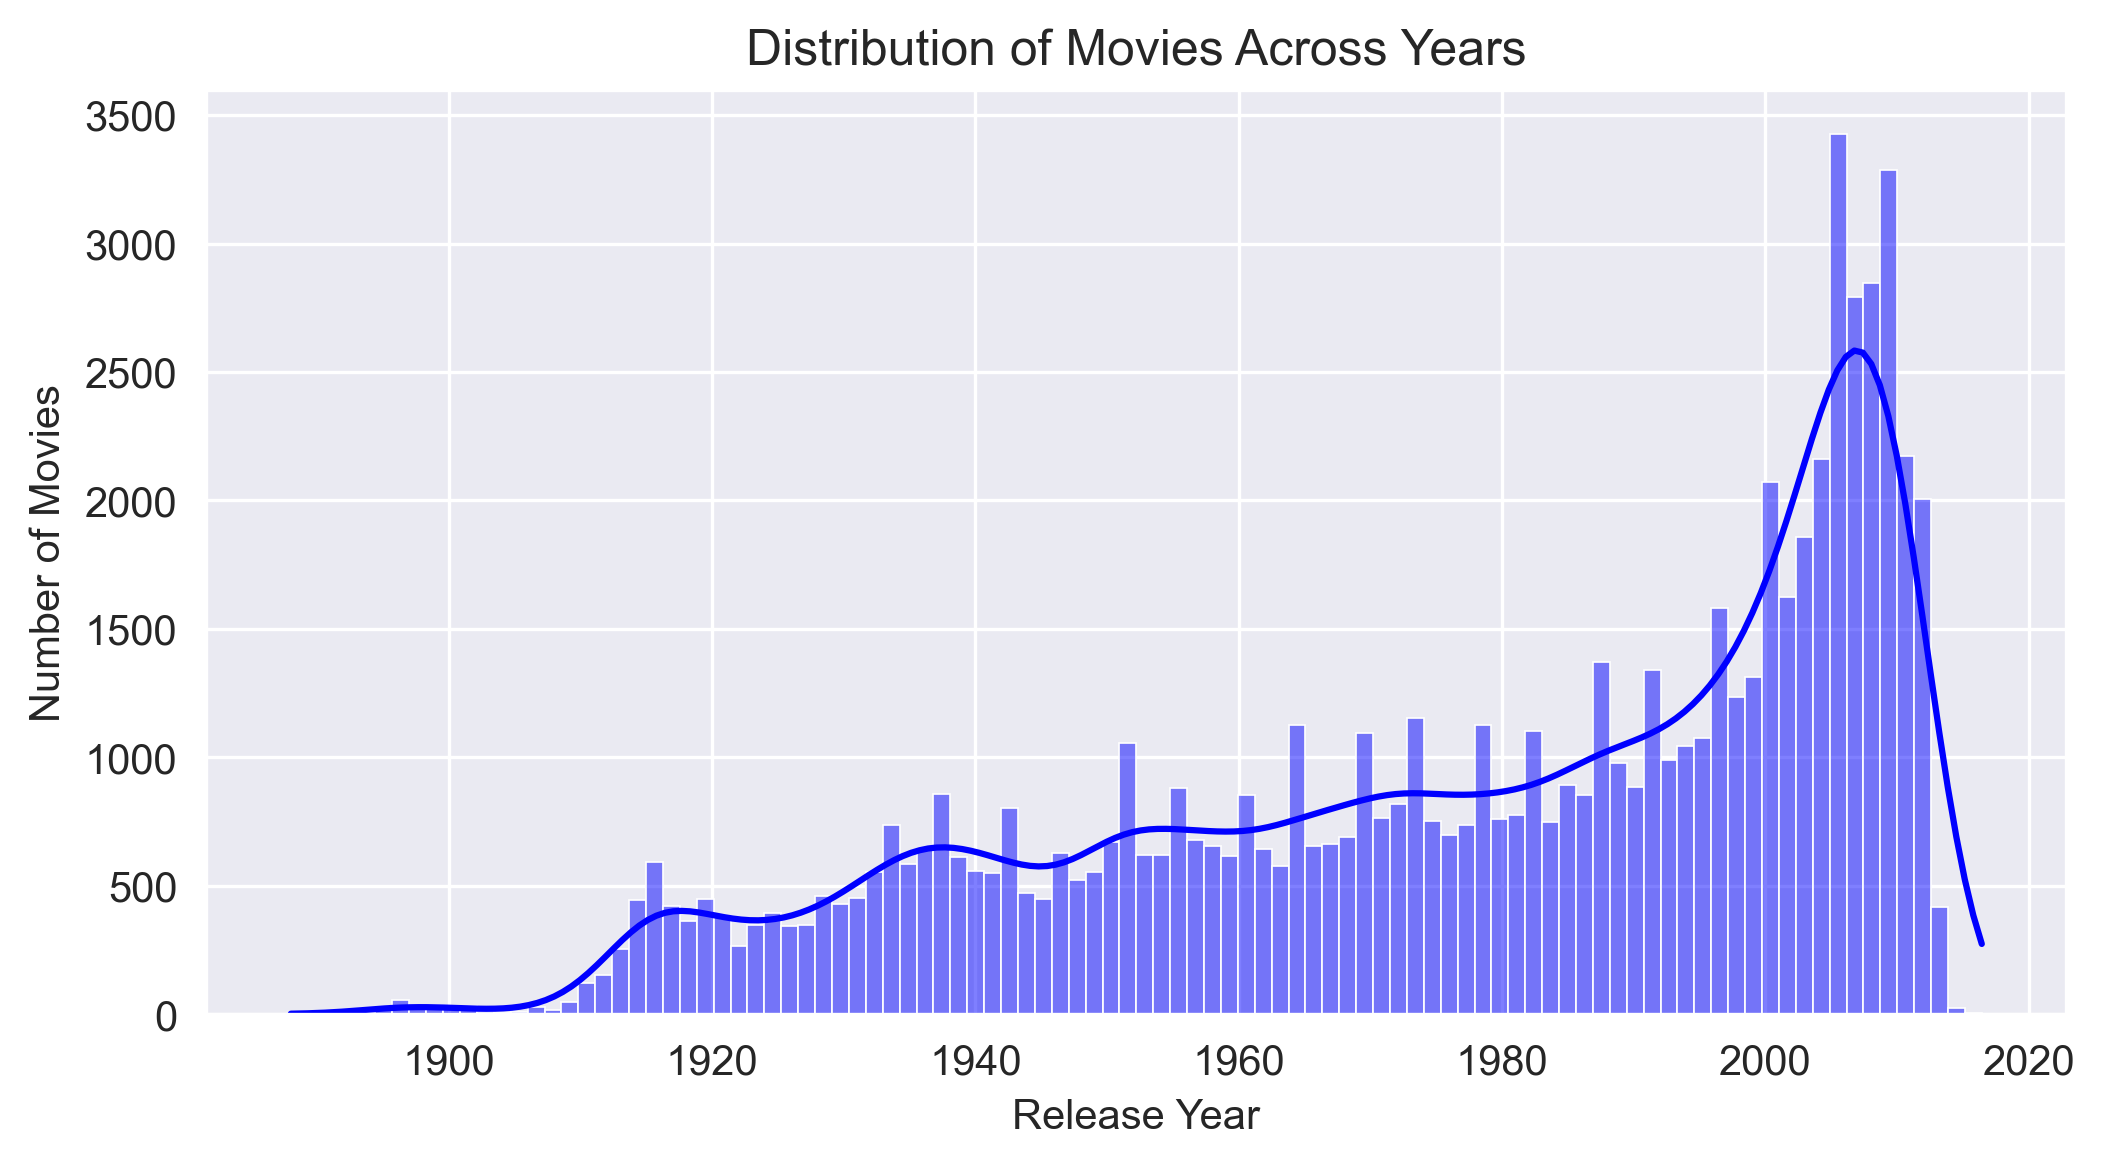

In [9]:
viz.visualize_year_distribution(movie_df)

Todo: Explain

## II.2 Missing values analysis

                            Missing Values  Percentage
actor_ethni_fbid                    124585   73.230587
writer_gender                       111745   65.683284
writer                              108500   63.775885
actor_height_meters                  92723   54.502225
movie_bo_revenue                     88380   51.949426
character_name                       78713   46.267200
fbid_char                            78709   46.264849
producer_gender                      59689   35.084966
producer                             56417   33.161697
actor_age_at_movie_release           44672   26.258031
actor_date_of_birth                  33323   19.587132
actor_gender                         15149    8.904524
director_gender                       6049    3.555579
movie_runtime                         2266    1.331946
director                               983    0.577804
actor_name                             367    0.215721
fbid_actor                             297    0.174575


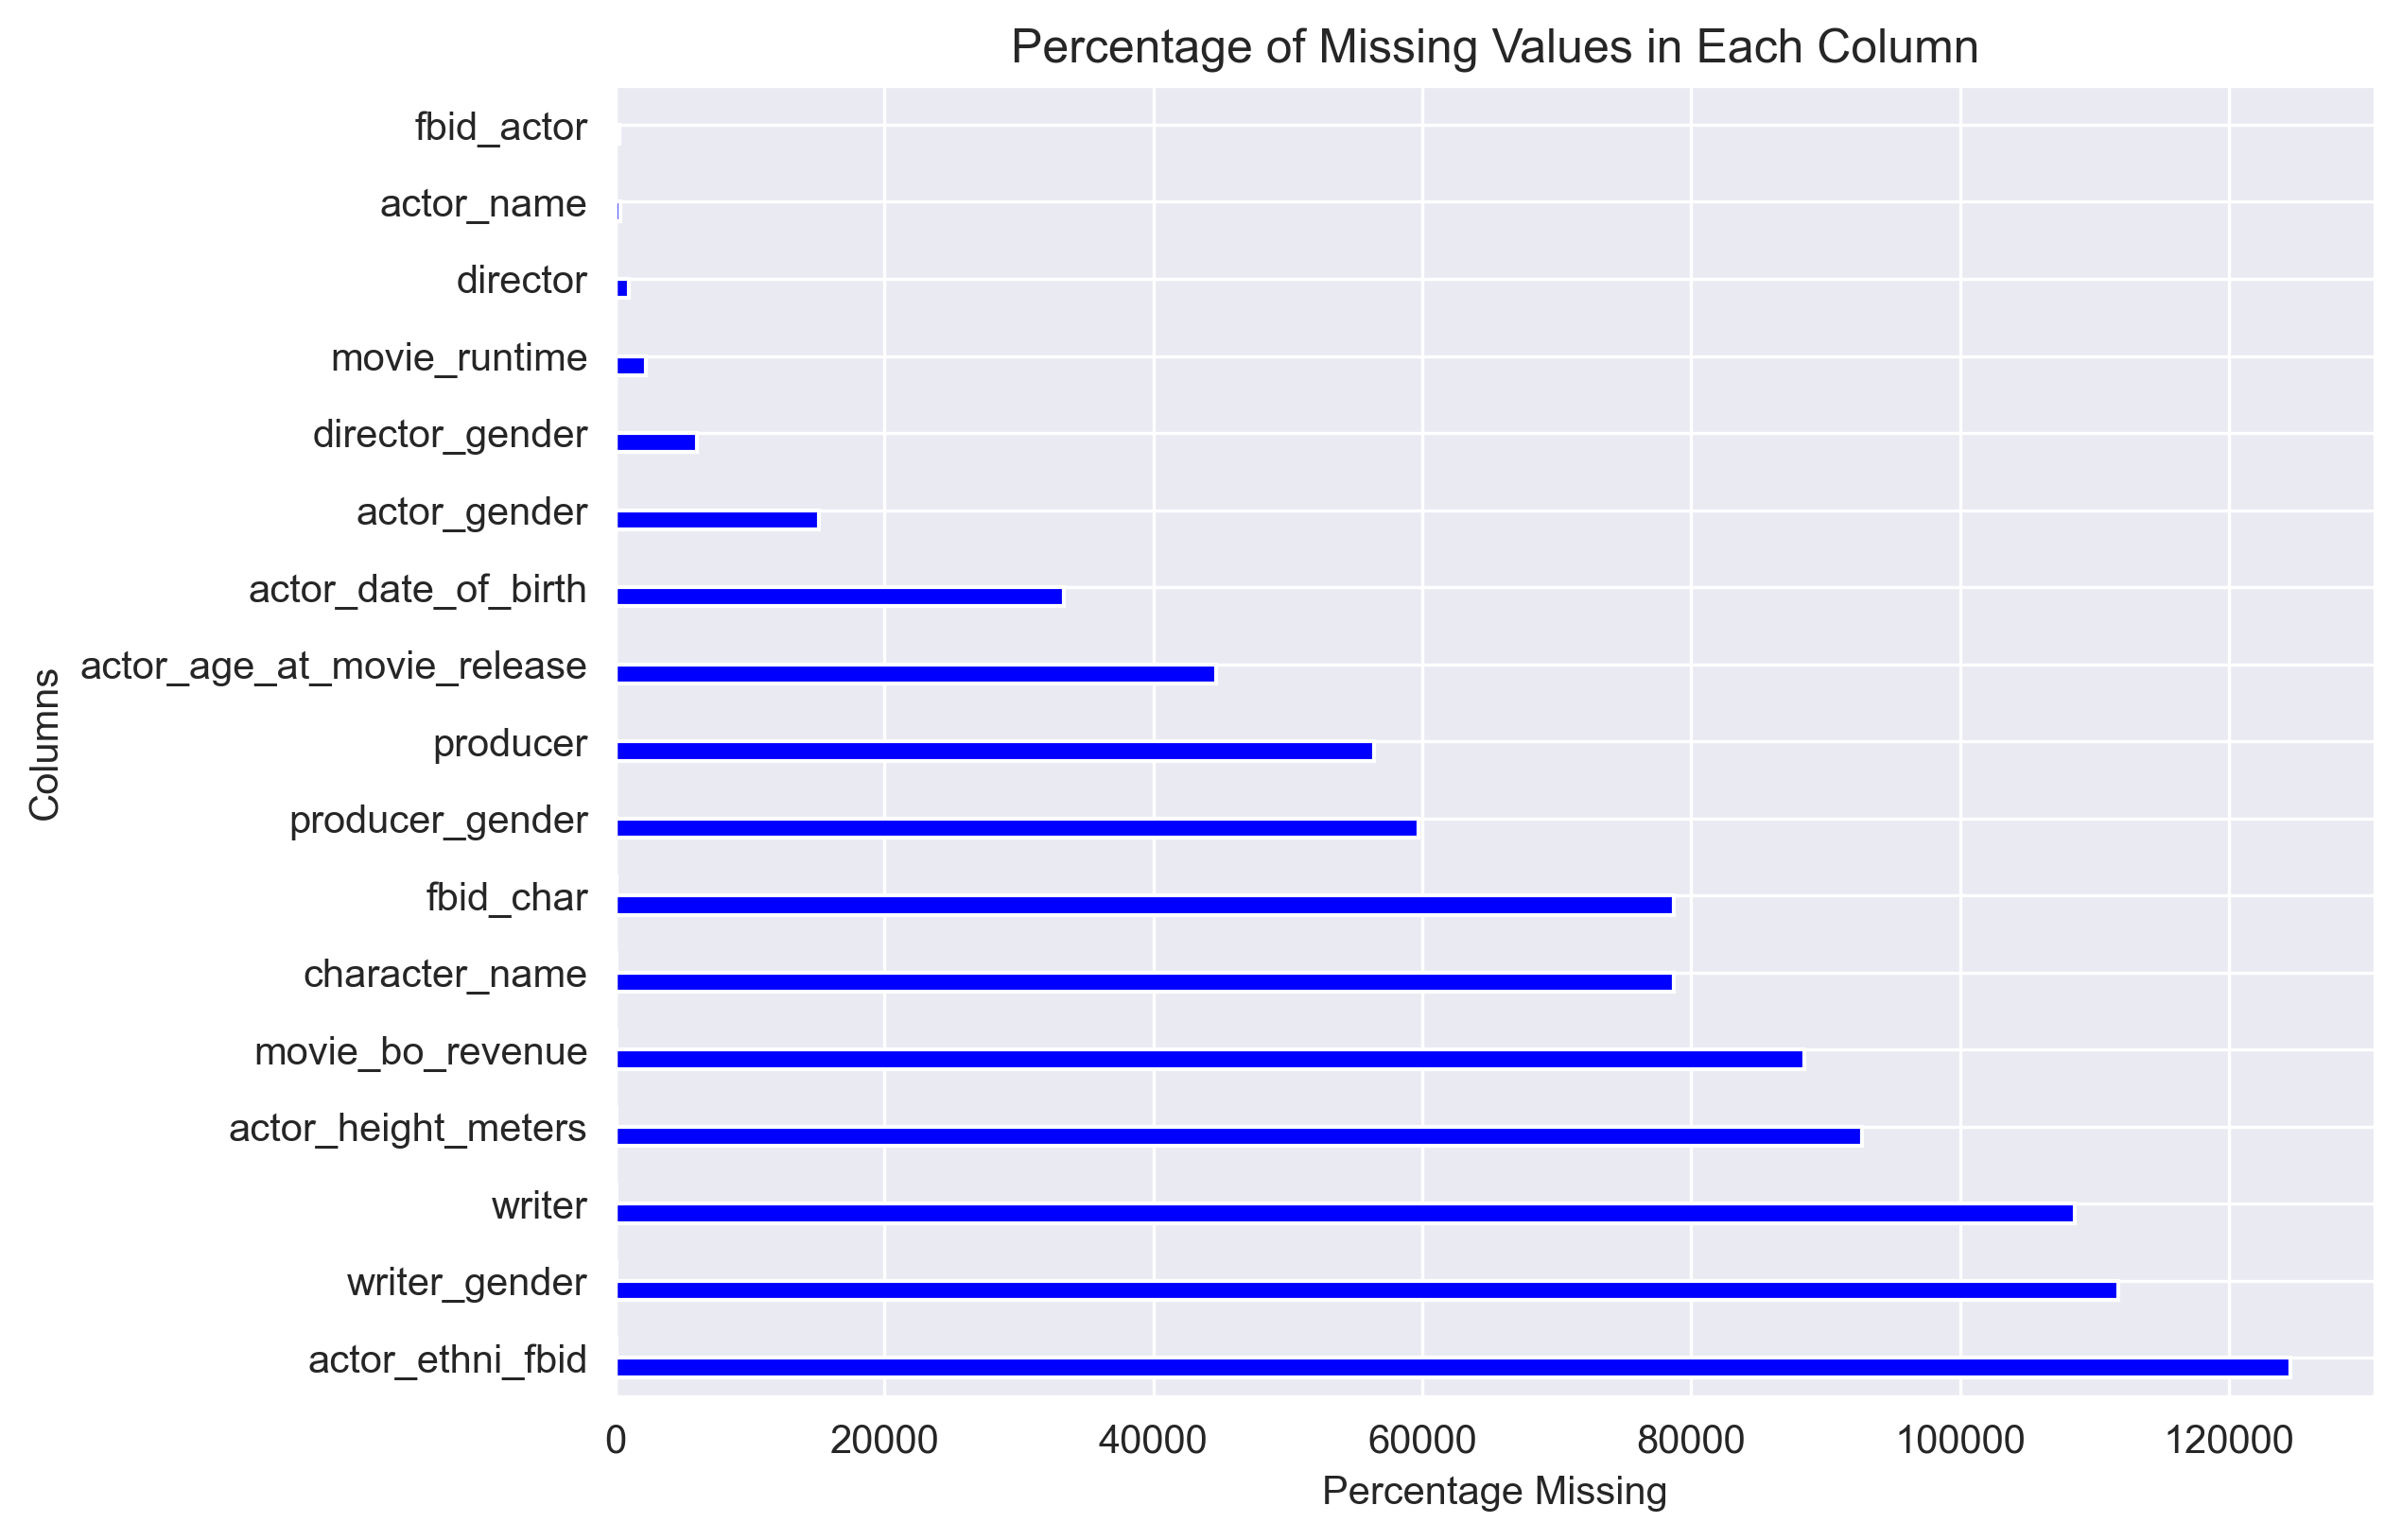

In [10]:
viz.visualize_missing_values(movies)

 Based on this analysis, drop columns with a lot of missing values  (according to a threshold, say 50%)

# II.3 Distribution of Key Features

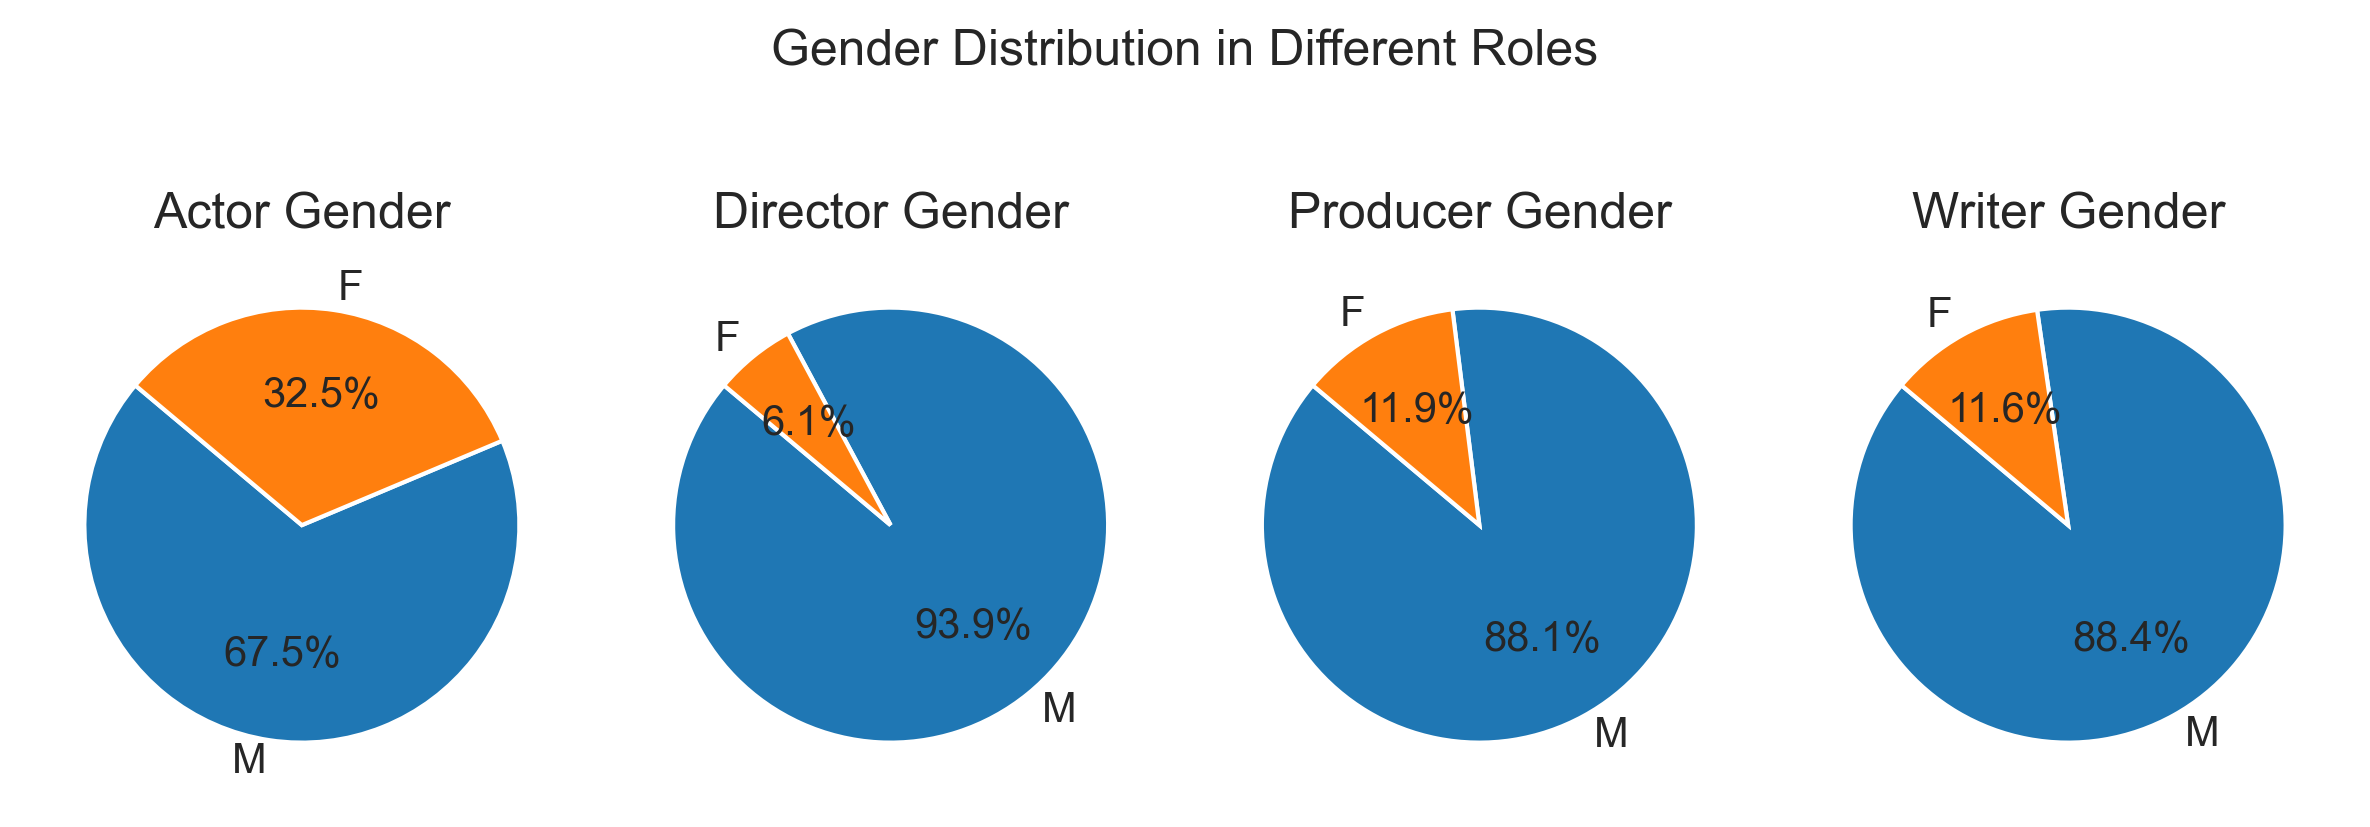

In [11]:
viz.visualize_gender_distribution(movies)

Todo: Explain

## III. More in-depth Analysis (P3 ?)

## III.1. Proportion of Female Characters

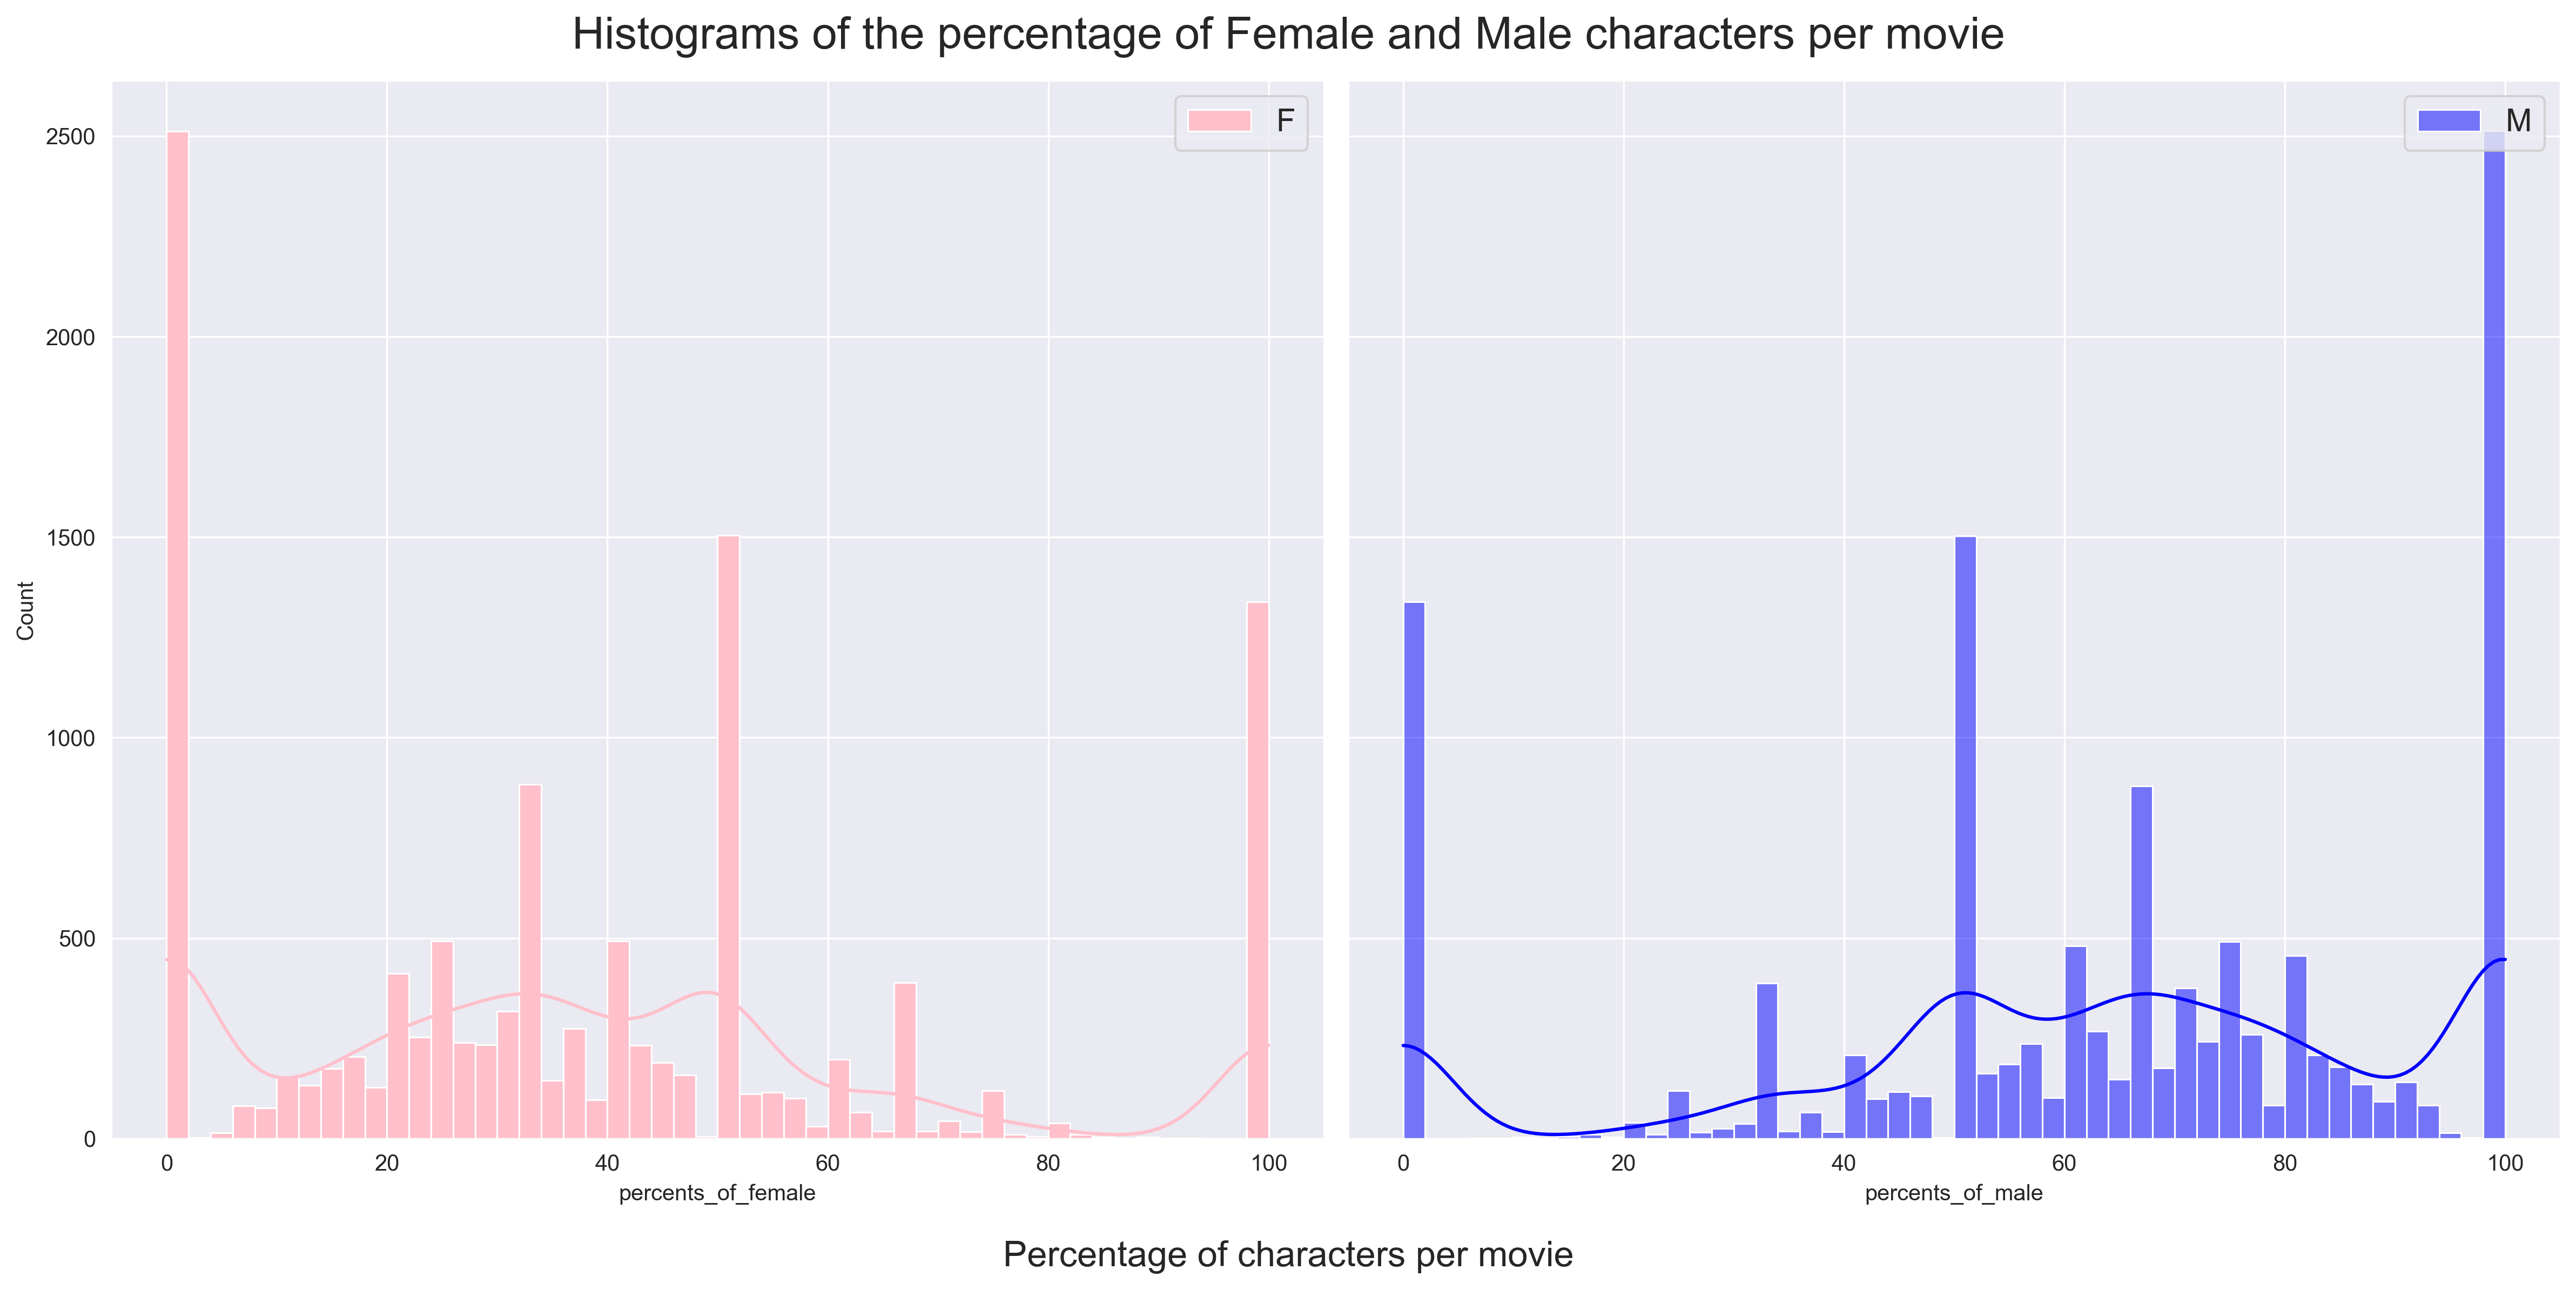

In [51]:
# TODO: document this and refactor
movies = movies.loc[movies['actor_gender'].isin(['F', 'M'])].copy(deep=True)
male_female_counts = movies.groupby(['wikiID', 'actor_gender'])['character_name'].nunique().unstack(fill_value=0)
male_female_counts = (
    male_female_counts
    .join(movies.groupby('wikiID')['character_name'].nunique().rename('total_char'))
    .assign(
        percents_of_female=lambda x: x['F'] / x['total_char'] * 100,
        percents_of_male=lambda x: x['M'] / x['total_char'] * 100
    )
)

male_female_counts.rename(columns={'F': 'female_char', 'M': 'male_char'}, inplace=True)
male_female_counts = (
    male_female_counts
    .merge(movies[['year', 'wikiID']].drop_duplicates(), on='wikiID', how='left')
)

male_female_counts.dropna(inplace=True, subset=['percents_of_female', 'percents_of_male'])

#Plot
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)

sns.histplot(male_female_counts['percents_of_female'], bins=50, label='F', alpha=1, color='pink', ax=ax[0], kde=True)
ax[0].legend(loc='upper right', fontsize=14) 

sns.histplot(male_female_counts['percents_of_male'], bins=50, label='M', alpha=0.5, color='blue', ax=ax[1], kde=True)
ax[1].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()
plt.show()

## III.2. Success Analysis

In the section, we would like to explore the relation between the success of a movie and the proportion of women actress. To do this we will use as a « success metric » the box-office revenue, the popularity and the ratings (provided by the TMDB dataset). 